In [1]:
import os

os.environ["KAGGLE_USERNAME"] = "YOUR_KAGGLE_USERNAME"
os.environ["KAGGLE_KEY"] = "YOUR_KAGGLE_KEY"

! pip install transformers obonet biopython peft --quiet
! kaggle competitions download -c "cafa-5-protein-function-prediction"
! unzip cafa-5-protein-function-prediction.zip

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 33.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.6/85.6 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 43.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 51.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.0/261.0 kB 29.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 29.5 MB/s eta 0:00:00
 90% 104M/115M [00:01<00:00, 95.3MB/s]
100% 115M/115M [00:01<00:00, 111MB/s] 
Archive:  cafa-5-protein-function-prediction.zip
  inflating: IA.txt                  
  inflating: Test (Targets)/testsuperset-taxon-list.tsv  
  inflating: Test (Targets)/testsuperset.fasta  
  inflating: Train/go-basic.obo      
  inflating: Train/train_sequences.fasta  
 

In [2]:
import obonet
from Bio import SeqIO
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import trange, tqdm
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import RocCurveDisplay, recall_score, precision_score, accuracy_score, f1_score
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel, logging
from peft import LoraConfig, get_peft_model

logging.set_verbosity_error()

In [3]:
np.random.seed(42)
mlb = MultiLabelBinarizer()

# Mapping between proteins and gene ontology functions
train_terms = pd.read_csv("./Train/train_terms.tsv", sep="\t")
functions = train_terms.groupby("EntryID")["term"].apply(list)
functions_df = pd.DataFrame(mlb.fit_transform(functions), columns=mlb.classes_, index=functions.index)
functions_df = functions_df[functions_df.sum(axis=0).sort_values(ascending=False)[:1000].index]
functions_df = functions_df.loc[functions_df.sum(axis=1).sort_values(ascending=False)[:10000].index]
functions_df = functions_df[np.random.permutation(functions_df.columns)].sample(frac=1)
functions = functions_df.apply(lambda row: row.index[row == 1].tolist(), axis=1).to_dict()

# Description of each gene ontology function
go_graph = obonet.read_obo("./Train/go-basic.obo")
go_to_desc = {id_: (data.get("namespace") + data.get("def")).replace("_", " ").replace('"', " ") for id_, data in go_graph.nodes(data=True)}
go_to_desc = {k: go_to_desc[k] for k in functions_df.columns}

# Amino-acid sequence of each protein
protein_to_seq = SeqIO.to_dict(SeqIO.parse(open("./Train/train_sequences.fasta"), "fasta"))
protein_to_seq = {k: protein_to_seq[k] for k in functions_df.index}

In [4]:
class ProteinsDataset(Dataset):

    def __init__(self, protein_to_seq, go_to_desc, functions):

        self.protein_list = list(protein_to_seq.keys())
        self.protein_to_seq = protein_to_seq
        self.go_list = list(go_to_desc.keys())
        self.go_to_desc = go_to_desc
        self.functions = functions

        self.protein_tokenizer = AutoTokenizer.from_pretrained("yarongef/DistilProtBert")
        self.go_tokenizer = AutoTokenizer.from_pretrained("nlpie/distil-biobert")

    def __len__(self):
        return len(self.protein_to_seq) * len(self.go_to_desc)

    def __getitem__(self, idx):

        # Retrieve the protein sequence
        protein_idx = idx // len(self.go_to_desc)
        protein_name = self.protein_list[protein_idx]
        protein_sequence = " ".join(str(self.protein_to_seq[protein_name].seq))

        # Retrieve the gene ontology description
        go_idx = idx - protein_idx * len(self.go_to_desc)
        go_name = self.go_list[go_idx]
        go_description = self.go_to_desc[go_name]

        # Retrieve the label
        label = float(go_name in self.functions[protein_name])

        # Tokenize sequences
        protein_inputs = self.protein_tokenizer.encode_plus(protein_sequence, padding="max_length",
                                                            max_length=1024, truncation=True, return_tensors="pt")
        go_inputs = self.go_tokenizer.encode_plus(go_description, padding="max_length",
                                                  max_length=256, truncation=True, return_tensors="pt")

        protein_input_ids = protein_inputs["input_ids"].squeeze()
        protein_attention_mask = protein_inputs["attention_mask"].squeeze()
        go_input_ids = go_inputs["input_ids"].squeeze()
        go_attention_mask = go_inputs["attention_mask"].squeeze()

        return protein_input_ids, protein_attention_mask, go_input_ids, go_attention_mask, label

In [5]:
batch_size = 32

train_dataset = ProteinsDataset({k: protein_to_seq[k] for k in list(protein_to_seq)[:100]},
                          {k: go_to_desc[k] for k in list(go_to_desc)[:100]},
                          functions)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = ProteinsDataset({k: protein_to_seq[k] for k in list(protein_to_seq)[100:120]},
                              {k: go_to_desc[k] for k in list(go_to_desc)[100:120]},
                              functions)

val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

In [6]:
class ProteinPredictor(nn.Module):

    def __init__(self):
        super(ProteinPredictor, self).__init__()

        # Load the pre-trained models
        self.protein_model = AutoModel.from_pretrained("yarongef/DistilProtBert")
        self.go_model = AutoModel.from_pretrained("nlpie/distil-biobert")

        # Define linear layers for mapping embeddings to hidden dimensions
        self.protein_embedding_dim = self.protein_model.config.hidden_size
        self.go_embedding_dim = self.go_model.config.hidden_size

        # Reshape
        self.protein_reshape = nn.Linear(self.protein_embedding_dim, 256)
        self.go_reshape = nn.Linear(self.go_embedding_dim, 256)

        # Final MLP prediction
        self.mlp = nn.Sequential(
            nn.Linear(3 * 256, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, 1)
        )

    def forward(self, protein_input_ids, protein_attention_mask, go_input_ids, go_attention_mask):

        # Generate protein embeddings
        protein_outputs = self.protein_model(input_ids=protein_input_ids, attention_mask=protein_attention_mask)
        protein_embeddings = protein_outputs.last_hidden_state.mean(dim=1)  # Mean pooling over sequence length

        # Generate gene ontology embeddings
        go_outputs = self.go_model(input_ids=go_input_ids, attention_mask=go_attention_mask)
        go_embeddings = go_outputs.last_hidden_state.mean(dim=1)  # Mean pooling over sequence length

        # Reshape
        protein_embeddings_reshaped = torch.tanh(self.protein_reshape(protein_embeddings))
        go_embeddings_reshaped = torch.tanh(self.go_reshape(go_embeddings))

        # Concatenate embeddings
        combined_embeddings = torch.cat((protein_embeddings_reshaped,
                                         go_embeddings_reshaped,
                                         torch.absolute(protein_embeddings_reshaped - go_embeddings_reshaped)), dim=1)

        output = self.mlp(combined_embeddings)

        return output

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

config = LoraConfig(
    r=8,
    lora_dropout=0.1,
    target_modules=[
        "go_model.encoder.layer.0.output.dense",
        "go_model.encoder.layer.3.output.dense",
        "go_model.encoder.layer.5.output.dense",
        "protein_model.encoder.layer.13.output.dense",
        "protein_model.encoder.layer.14.output.dense"],
    modules_to_save=[
        "protein_reshape",
        "go_reshape",
        "mlp.0",
        "mlp.2"]
)

model = ProteinPredictor()
peft_model = get_peft_model(model, config)
peft_model.print_trainable_parameters()
model = peft_model.to(device)

In [8]:
pos_weight = (1 - functions_df.iloc[:100][functions_df.columns[:100]].mean().mean()) / functions_df.iloc[:100][functions_df.columns[:100]].mean().mean()

In [9]:
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, amsgrad=True)
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(pos_weight).to(device))
num_epochs = 3

In [10]:
scaler = torch.cuda.amp.GradScaler(enabled=True)
bar = trange(num_epochs)

loss_history = []
val_loss_history = []

for epoch in bar:

    # Training step
    model.train()
    for protein_input_ids, protein_attention_mask, go_input_ids, go_attention_mask, labels in train_dataloader:

        with torch.autocast(device_type=device.type, dtype=torch.float16, enabled=True):

            protein_input_ids = protein_input_ids.to(device)
            protein_attention_mask = protein_attention_mask.to(device)
            go_input_ids = go_input_ids.to(device)
            go_attention_mask = go_attention_mask.to(device)
            labels = labels.to(device)

            outputs = model(protein_input_ids, protein_attention_mask, go_input_ids, go_attention_mask)
            loss = criterion(outputs, labels.unsqueeze(1).float())

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

        loss_history.append(loss.item())
        bar.set_postfix(loss=f"{np.mean(loss_history[-train_dataset.__len__()//batch_size:]):,.3f}")

    # Evaluation step
    model.eval()
    for protein_input_ids, protein_attention_mask, go_input_ids, go_attention_mask, labels in val_dataloader:

        val_loss = []

        with torch.no_grad():

            protein_input_ids = protein_input_ids.to(device)
            protein_attention_mask = protein_attention_mask.to(device)
            go_input_ids = go_input_ids.to(device)
            go_attention_mask = go_attention_mask.to(device)
            labels = labels.to(device)

            outputs = model(protein_input_ids, protein_attention_mask, go_input_ids, go_attention_mask)
            loss = criterion(outputs, labels.unsqueeze(1).float())

            val_loss.append(loss.item())

    val_loss_history.append(np.mean(val_loss))

  0%|          | 0/3 [00:00<?, ?it/s]

In [14]:
# Training data

model.eval()
y_pred = []
y_true = []

for i in tqdm(range(train_dataset.__len__())):

    with torch.no_grad():

        protein_input_ids, protein_attention_mask, go_input_ids, go_attention_mask, label = train_dataset.__getitem__(i)

        protein_input_ids = torch.reshape(protein_input_ids, (1, 1024)).to(device)
        protein_attention_mask = torch.reshape(protein_attention_mask, (1, 1024)).to(device)
        go_input_ids = torch.reshape(go_input_ids, (1, 256)).to(device)
        go_attention_mask = torch.reshape(go_attention_mask, (1, 256)).to(device)

        output = model(protein_input_ids, protein_attention_mask, go_input_ids, go_attention_mask)
        y_true.append(label)
        y_pred.append(torch.sigmoid(output).item())

  0%|          | 0/10000 [00:00<?, ?it/s]

Recall: 0.684
Precision: 0.297
F1-Score: 0.415


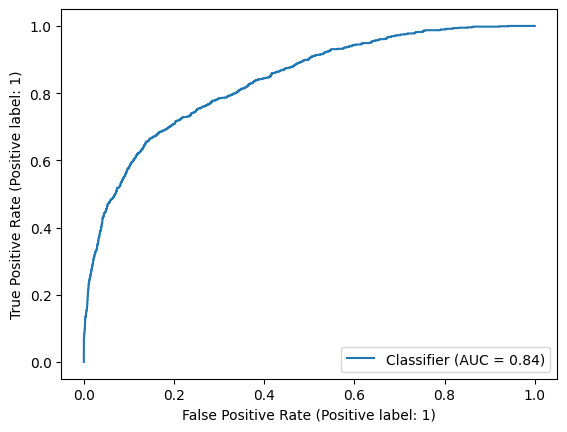

In [15]:
RocCurveDisplay.from_predictions(y_true, y_pred)
print(f"Recall: {recall_score(y_true, (np.asarray(y_pred) > 0.5).astype(int)):.3f}")
print(f"Precision: {precision_score(y_true, (np.asarray(y_pred) > 0.5).astype(int)):.3f}")
print(f"F1-Score: {f1_score(y_true, (np.asarray(y_pred) > 0.5).astype(int)):.3f}")

In [16]:
# Seen proteins, unseen functions

test_dataset = ProteinsDataset({k: protein_to_seq[k] for k in list(protein_to_seq)[:100]},
                               {k: go_to_desc[k] for k in list(go_to_desc)[100:200]},
                               functions)

test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [17]:
model.eval()
y_pred = []
y_true = []

for i in tqdm(range(test_dataset.__len__())):

    with torch.no_grad():

        protein_input_ids, protein_attention_mask, go_input_ids, go_attention_mask, label = test_dataset.__getitem__(i)

        protein_input_ids = torch.reshape(protein_input_ids, (1, 1024)).to(device)
        protein_attention_mask = torch.reshape(protein_attention_mask, (1, 1024)).to(device)
        go_input_ids = torch.reshape(go_input_ids, (1, 256)).to(device)
        go_attention_mask = torch.reshape(go_attention_mask, (1, 256)).to(device)

        output = model(protein_input_ids, protein_attention_mask, go_input_ids, go_attention_mask)
        y_true.append(label)
        y_pred.append(torch.sigmoid(output).item())

  0%|          | 0/10000 [00:00<?, ?it/s]

Recall: 0.374
Precision: 0.142
F1-Score: 0.206


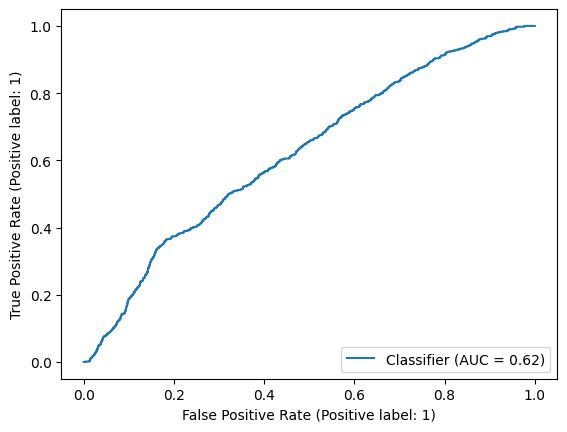

In [18]:
RocCurveDisplay.from_predictions(y_true, y_pred)
print(f"Recall: {recall_score(y_true, (np.asarray(y_pred) > 0.5).astype(int)):.3f}")
print(f"Precision: {precision_score(y_true, (np.asarray(y_pred) > 0.5).astype(int)):.3f}")
print(f"F1-Score: {f1_score(y_true, (np.asarray(y_pred) > 0.5).astype(int)):.3f}")

In [19]:
# Unseen proteins, seen functions

test_dataset = ProteinsDataset({k: protein_to_seq[k] for k in list(protein_to_seq)[100:200]},
                               {k: go_to_desc[k] for k in list(go_to_desc)[:100]},
                               functions)

test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
model.eval()
y_pred = []
y_true = []

for i in tqdm(range(test_dataset.__len__())):

    with torch.no_grad():

        protein_input_ids, protein_attention_mask, go_input_ids, go_attention_mask, label = test_dataset.__getitem__(i)

        protein_input_ids = torch.reshape(protein_input_ids, (1, 1024)).to(device)
        protein_attention_mask = torch.reshape(protein_attention_mask, (1, 1024)).to(device)
        go_input_ids = torch.reshape(go_input_ids, (1, 256)).to(device)
        go_attention_mask = torch.reshape(go_attention_mask, (1, 256)).to(device)

        output = model(protein_input_ids, protein_attention_mask, go_input_ids, go_attention_mask)
        y_true.append(label)
        y_pred.append(torch.sigmoid(output).item())

  0%|          | 0/10000 [00:00<?, ?it/s]

In [ ]:
RocCurveDisplay.from_predictions(y_true, y_pred)
print(f"Recall: {recall_score(y_true, (np.asarray(y_pred) > 0.5).astype(int)):.3f}")
print(f"Precision: {precision_score(y_true, (np.asarray(y_pred) > 0.5).astype(int)):.3f}")
print(f"F1-Score: {f1_score(y_true, (np.asarray(y_pred) > 0.5).astype(int)):.3f}")

In [ ]:
# Unseen proteins, unseen functions

test_dataset = ProteinsDataset({k: protein_to_seq[k] for k in list(protein_to_seq)[100:200]},
                               {k: go_to_desc[k] for k in list(go_to_desc)[100:200]},
                               functions)

test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
model.eval()
y_pred = []
y_true = []

for i in tqdm(range(test_dataset.__len__())):

    with torch.no_grad():

        protein_input_ids, protein_attention_mask, go_input_ids, go_attention_mask, label = test_dataset.__getitem__(i)

        protein_input_ids = torch.reshape(protein_input_ids, (1, 1024)).to(device)
        protein_attention_mask = torch.reshape(protein_attention_mask, (1, 1024)).to(device)
        go_input_ids = torch.reshape(go_input_ids, (1, 256)).to(device)
        go_attention_mask = torch.reshape(go_attention_mask, (1, 256)).to(device)

        output = model(protein_input_ids, protein_attention_mask, go_input_ids, go_attention_mask)
        y_true.append(label)
        y_pred.append(torch.sigmoid(output).item())

In [ ]:
RocCurveDisplay.from_predictions(y_true, y_pred)
print(f"Recall: {recall_score(y_true, (np.asarray(y_pred) > 0.5).astype(int)):.3f}")
print(f"Precision: {precision_score(y_true, (np.asarray(y_pred) > 0.5).astype(int)):.3f}")
print(f"F1-Score: {f1_score(y_true, (np.asarray(y_pred) > 0.5).astype(int)):.3f}")